## Dynamics on Dipolar Pake Pattern

## Goals
Simulate how dynamics change static pake pattern 
## system setup
we use diffusion on the cone as the model system
the bond vector is retreated as H-N bond

## How-to
1. simulte diffusion on a cone to get the bond vector (check)
2. calculate according chemical shift values for each orientation of the bone vector
3. generate Ix or Ix + iIj trajactory: Ix = cos(theta), theta = dt*frequency (rad/s)    frequency = ppm* B0 * 2pi
4. FT to the frequency conponent 
5. figure out how to emsemble average: can we still use Wigner-D matrix 


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.spatial.transform import Rotation as R
import sympy as sp
from sympy.physics.quantum.spin import Rotation as WignerRotation
import numpy as np
import math
from math import factorial as fact

# --- Step 1: Simulate vector trajectory on a cone ---
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)
    phi = 0.0
    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vectors[i] = np.array([x, y, z])
    return vectors



# alternative step 1
def simulate_vector_on_cone2(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000, axis=np.array([0, 0, 1])):
    """
    Simulate a unit vector hopping on a cone surface with fixed S2 and correlation time tau_c.
    
    Returns:
        vectors: (num_steps, 3) array of unit vectors
    """
    # Cone angle from S²
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)

    # Ornstein-Uhlenbeck parameters for azimuthal diffusion
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)  # Unit noise strength
    phi = 0.0
    axis = axis / np.linalg.norm(axis)

    # Rotation matrix to align cone with axis
    R_align = rotation_matrix_from_vectors(np.array([0, 0, 1]), axis)

    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        # Update azimuthal angle using Ornstein-Uhlenbeck process
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi

        # Point on cone with fixed θ and current φ
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vec_local = np.array([x, y, z])

        # Rotate to align cone with specified axis
        vec_global = R_align @ vec_local
        vectors[i] = vec_global

    return vectors

def rotation_matrix_from_vectors(a, b):
    """Find the rotation matrix that aligns vector a to vector b"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    v = np.cross(a, b)
    c = np.dot(a, b)
    if c == 1:
        return np.eye(3)
    if c == -1:
        # 180° rotation around arbitrary perpendicular axis
        perp = np.array([1, 0, 0]) if not np.allclose(a, [1, 0, 0]) else np.array([0, 1, 0])
        return rotation_matrix_from_vectors(a, np.cross(a, perp))
    s = np.linalg.norm(v)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    return np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))

In [21]:
# test of step 1
HN_vector = simulate_vector_on_cone2(S2=0.85, tau_c=0.0001, dt=1e-6, num_steps=10000,axis=np.array([1,0,0]))
print("HN_vector shape:", HN_vector.shape)

HN_vector shape: (10000, 3)


In [2]:
# module for step 2
# write Spatial part of the spherical harmonics for dipolar interaction with axis along z, only rank=2, other is  zero
import sympy as sp
from sympy.physics.quantum.spin import Rotation

# note: when we need study both CSA and Dipolar, T_2m need to be calculated in the principal axis system of the CSA tensor

T_2m = {
    -2: 0,
    -1: 0,
    0: sp.sqrt(3/2) * (-2),
    1: 0,
    2: 0
}
# define the Wigner D-matrix elements for rank l=2 
# using the sympy Rotation module
# def D_matrix(l, m, m_prime, alpha, beta, gamma):
#     R = Rotation.D(l, m, m_prime, alpha, beta, gamma)
#     return sp.simplify(R.doit())


# now calculate the components after rotation with euler angles alpha, beta, gamma
def rotate_sph_harmonics(T, alpha, beta, gamma):
    T_rot = {}
    for m in T:
        T_rot[m] = sum(
            sp.simplify(T[m_prime] * Rotation.D(2, m, m_prime, alpha, beta, gamma))
            for m_prime in T
        )
    return T_rot

alpha, beta, gamma = sp.symbols('alpha beta gamma', real=True)

T_rot = rotate_sph_harmonics(T_2m, alpha, beta, gamma)

In [ ]:
#---step 2. Convert H-N orientaion to chemical shift frequency----

r = 1.0e-10  # distance between the two spins in meters 1 å
gamma1 = 2.675e8  # gyromagnetic ratio for proton in /s/T
# gyromagnetic ratio for nitrogen in rad/s/T
gamma2 = 2.713e7  # gyromagnetic ratio for nitrogen-15 in /s/T
gamma3= 6.728e7 # gyro for carbon-13 /s/T

def dipolar_prefactor_Hz(r, gamma1, gamma2):
    mu_0 = 4 * sp.pi * 1e-7  # T·m/A
    hbar = 1.0545718e-34     # J·s
    h = 6.62607015e-34       # Planck's constant in J·s

    # Energy in joules
    H_dip_J = - (mu_0 / (4 * sp.pi)) * (gamma1 * gamma2 * hbar**2) / r**3

    # Convert to Hz: E / h
    H_dip_Hz = H_dip_J / h

    return H_dip_Hz

import numpy as np
from scipy.spatial.transform import Rotation as R

def euler_from_z_to_vec(v, seq='zyz', degrees=False):
    """
    Calculate Euler angles to rotate (0,0,1) onto one or more unit vectors.

    Parameters
    ----------
    v : array-like, shape (3,) or (N,3)
        Target unit vector(s).
    seq : str
        Euler angle sequence, e.g. 'xyz', 'zyx', 'zxz', etc.
    degrees : bool
        Return angles in degrees if True, radians otherwise.

    Returns
    -------
    euler_angles : ndarray, shape (3,) or (N,3)
        Euler angles that rotate (0,0,1) onto v.
    """
    v = np.atleast_2d(np.array(v, dtype=float))
    v /= np.linalg.norm(v, axis=1, keepdims=True)

    z_axis = np.array([0.0, 0.0, 1.0])
    cos_theta = np.clip(v @ z_axis, -1.0, 1.0)  # shape (N,)
    theta = np.arccos(cos_theta)

    # cross product to get rotation axis
    axis = np.cross(np.broadcast_to(z_axis, v.shape), v)
    axis_norm = np.linalg.norm(axis, axis=1, keepdims=True)
    axis = np.divide(axis, axis_norm, where=axis_norm>1e-15)  # avoid div by zero

    # default rotation vectors (general case)
    rotvec = axis * theta[:, None]

    # parallel case: theta ~ 0 → no rotation
    parallel_mask = np.isclose(theta, 0.0)
    rotvec[parallel_mask] = 0.0

    # anti-parallel case: theta ~ pi → rotate pi about any perpendicular axis
    antiparallel_mask = np.isclose(theta, np.pi)
    if np.any(antiparallel_mask):
        # pick axis perpendicular to z, use x unless z=[±1,0,0]
        fallback_axis = np.array([1.0,0.0,0.0])
        bad = np.isclose(np.abs(z_axis @ fallback_axis), 1.0)
        if bad:
            fallback_axis = np.array([0.0,1.0,0.0])
        rotvec[antiparallel_mask] = fallback_axis * np.pi

    # build rotation and convert to Euler
    rot = R.from_rotvec(rotvec)
    euler_angles = rot.as_euler(seq, degrees=degrees)

    # return shape (3,) if input was a single vector
    if euler_angles.shape[0] == 1:
        return euler_angles[0]
    return euler_angles


import numpy as np
import sympy as sp

# places to improve: convert symbolic expressions to numerical functions to improve performance

def xyz2freq(vectors, B0):
    """
    Convert xyz unit vectors to dipolar coupling frequencies for given orientations.

    Parameters
    ----------
    vectors : ndarray, shape (N, 3)
        Unit vectors representing orientations.
    B0 : float
        Magnetic field strength in Tesla.

    Returns
    -------
    frequencies : ndarray, shape (N,)
        Dipolar coupling frequencies (Hz) for each input orientation.
    """
    # --- Euler angles from z-axis to each vector ---
    euler_angles = euler_from_z_to_vec(vectors)    # shape (N,3)
    alpha_vals, beta_vals, gamma_vals = euler_angles.T

    # --- Symbolic definition ---
    alpha_sym, beta_sym, gamma_sym = sp.symbols('alpha beta gamma')

    # Dipolar prefactor (define r, gamma1, gamma2 externally)
    D = dipolar_prefactor_Hz(r, gamma1, gamma2)   # <-- Make sure B0 is used if needed!

    # Example expression for orientation dependence (adjust to your case)
    expr = D * T_rot[0] * sp.sqrt(2/sp.Integer(3))/2  # replace T_rot[0] with your actual tensor expression

    # --- Build vectorized numerical function ---
    expr_func = sp.lambdify((alpha_sym, beta_sym, gamma_sym), expr, modules='numpy')

    # --- Direct vectorized evaluation (no loop) ---
    frequencies = expr_func(alpha_vals, beta_vals, gamma_vals)
    return np.asarray(frequencies, dtype=float)


# instead of calculate only T2,0, we can calculate all T2,m
def xyz2T2m(vectors, B0):
    """
    Calculate all T2,m for given orientations.

    Parameters
    ----------
    vectors : ndarray, shape (N, 3)
        Unit vectors representing orientations.
    B0 : float
        Magnetic field strength in Tesla.

    Returns
    -------
    T2m : ndarray, shape (N, M)
        All T2,m values for each input orientation.
    """
 # --- Euler angles from z-axis to each vector ---
    euler_angles = euler_from_z_to_vec(vectors)    # shape (N,3)
    alpha_vals, beta_vals, gamma_vals = euler_angles.T

    # --- Symbolic definition ---
    alpha_sym, beta_sym, gamma_sym = sp.symbols('alpha beta gamma')

    # Dipolar prefactor (define r, gamma1, gamma2 externally)
    D = dipolar_prefactor_Hz(r, gamma1, gamma2)   # <-- Make sure B0 is used if needed!

    # Example expression for orientation dependence (adjust to your case)
    expr = D * T_rot * sp.sqrt(2/sp.Integer(3))/2  # replace T_rot with your actual tensor expression

    # --- Build vectorized numerical function ---
    expr_func = sp.lambdify((alpha_sym, beta_sym, gamma_sym), expr, modules='numpy')

    # --- Direct vectorized evaluation (no loop) ---
    frequencies = expr_func(alpha_vals, beta_vals, gamma_vals)
    return np.asarray(frequencies, dtype=float)




Frequencies shape: (10000,)


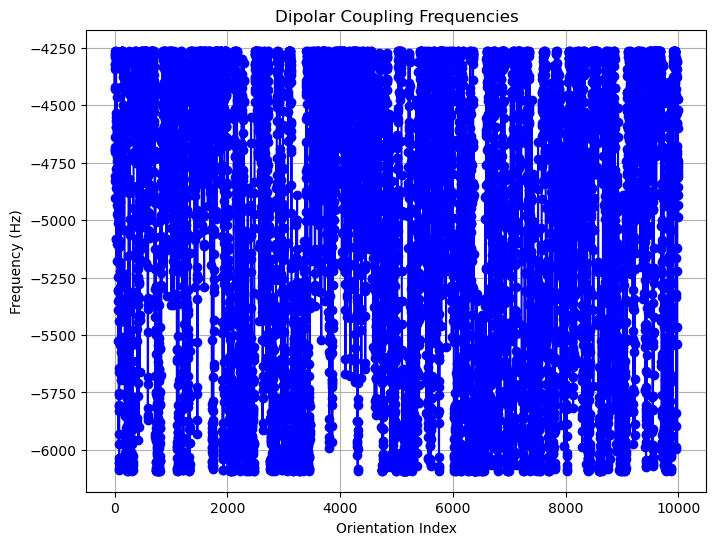

In [22]:
# test of step 2
frequencies = xyz2freq(HN_vector, B0=11.7)
print("Frequencies shape:", frequencies.shape)

# plot the frequencies
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(frequencies, marker='o', linestyle='-', color='b')
plt.title("Dipolar Coupling Frequencies")
plt.xlabel("Orientation Index")
plt.ylabel("Frequency (Hz)")
plt.grid()
plt.show()


In [77]:
## Step 3: Calculate Ix trajatory

# this is for single orientation

def calculate_Ix_trajectory(frequencies, dt):
    """
    Calculate the Ix trajectory based on the dipolar coupling frequencies and time points.

    Parameters
    ----------
    frequencies : array-like, shape (n,)
        Dipolar coupling frequencies.
    dt: float
        Time step for the simulation.
    time_points: int
        Number of time points to simulate.

    Returns
    -------
    Ix_trajectory : ndarray, shape (m,)
        Calculated Ix trajectory.
    """
    # first convert frequency to processing angles
    angles = 2 * np.pi * frequencies * dt


    # calculate cumulative sum of angles
    cum_angles = np.cumsum(angles)

    # calculate Ix at each time point as cos(cum_angles)
    Ix_trajectory = np.cos(cum_angles)
    Iy_trajectory = np.sin(cum_angles)

    return Ix_trajectory, Iy_trajectory


# this is for ensemble calcualtion

def calculate_Ip_trajectory(frequencies, dt):
    """
    Calculate ensemble-averaged Ix and Iy trajectories using cumulative angles.
    
    Parameters
    ----------
    frequencies : ndarray, shape (N, M, 1)
        Dipolar coupling frequencies for each ensemble member and time step.
    dt : float
        Time step for the simulation.
    
    Returns
    -------
    Ix_avg : ndarray, shape (M,)
        Ensemble-averaged Ix trajectory.
    Iy_avg : ndarray, shape (M,)
        Ensemble-averaged Iy trajectory.
    """
    frequencies = np.array(frequencies, dtype=float)  # shape (N, M, 1)
    
    # Phase increment per step
    delta_angles = 2 * np.pi * frequencies * dt  # shape (N, M, 1)
    
    # Cumulative angles along time axis (axis=1)
    cum_angles = np.cumsum(delta_angles, axis=1)  # shape (N, M, 1)
    
    # Compute Ix, Iy
    Ix = np.cos(cum_angles)  # shape (N, M, 1)
    Iy = np.sin(cum_angles)
    
    # Ensemble average over first axis (N)
    Ix_avg = Ix.mean(axis=0).squeeze()  # shape (M,)
    Iy_avg = Iy.mean(axis=0).squeeze()  # shape (M,)
    
    return Ix_avg, Iy_avg



In [78]:
# test step 3
dt = 1e-6
time_points = 500
Ix_test, Iy_test = calculate_Ix_trajectory(frequencies, dt)

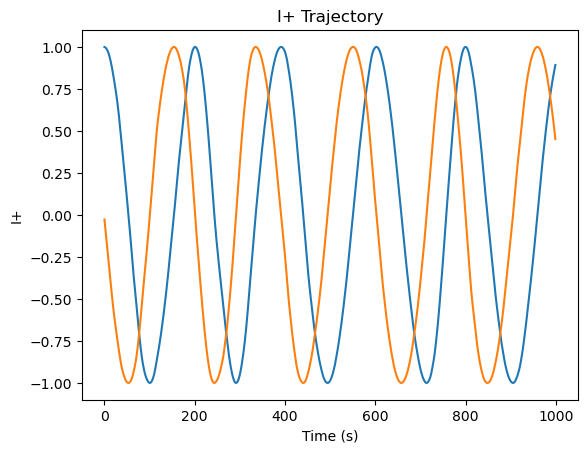

In [79]:
# plot Ix_test
import matplotlib.pyplot as plt
plt.plot(Ix_test[:1000])
plt.plot(Iy_test[:1000])
plt.xlabel('Time (s)')
plt.ylabel('I+')
plt.title('I+ Trajectory')
plt.show()

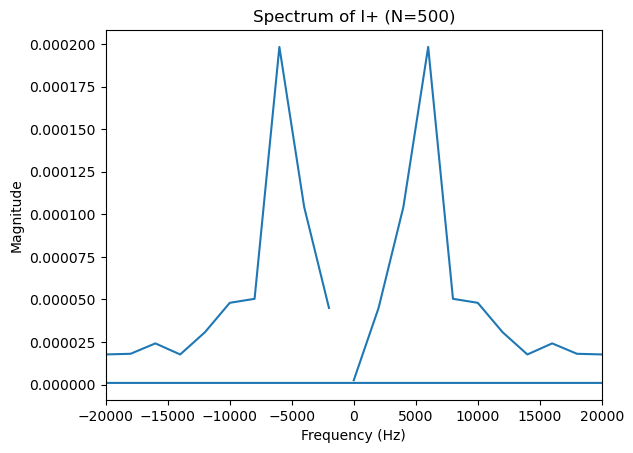

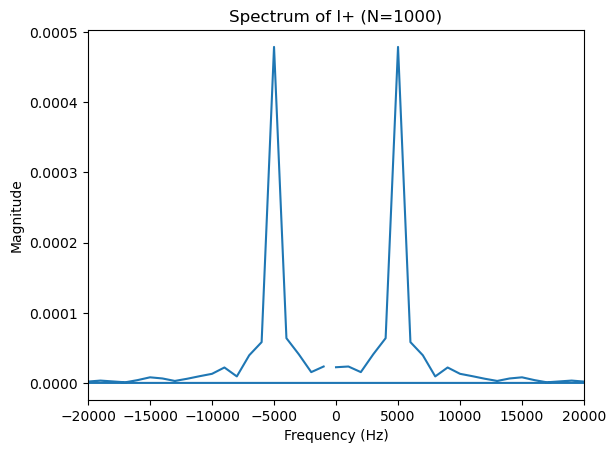

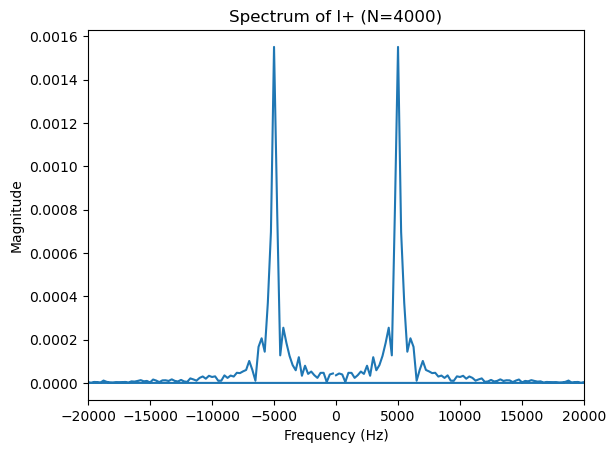

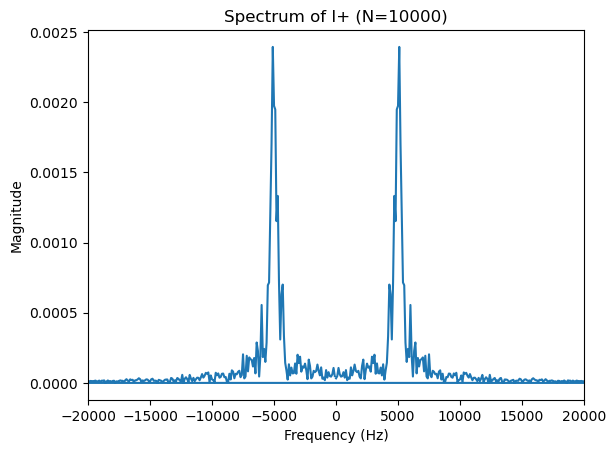

In [82]:
# step 4. convert Ix + iIy complex to spectrum through ft (for normal case)
#fft_vals = np.fft.fft(Ix_test+1j*Iy_test)

# for dipolar Interaction, both positive and negative frequencies are considered
# test data_points as 500 1000, 4000, 10000 and plot the results all together
data_points = [500, 1000, 4000, 10000]
for dp in data_points:
    fft_vals = np.fft.fft(Ix_test[:dp])
    freq = np.fft.fftfreq(len(Ix_test[:dp]), d=dt)
    # normalize
    fft_vals = fft_vals * dt

    #plot
    plt.plot(freq, np.abs(fft_vals))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Spectrum of I+ (N={dp})')
    plt.xlim(-20000, 20000)
    plt.show()

(10000, 3)


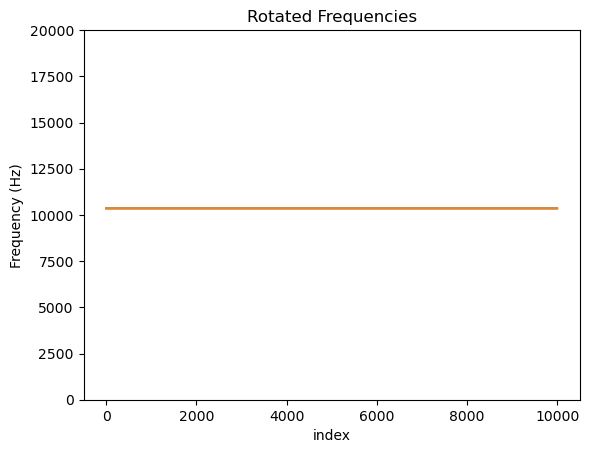

In [52]:
# step 5. calculate emsemble average

# in step 2, we calculate the freq for one orientation.
# now we need to use wigner_D matrix to extend the freq to all orientations

# test one angle first
rotation_test= rotation_matrix_from_vectors(np.array([1, 0, 0]), np.array([0, 0, 1]))   
#convert to eular angles
alpha, beta, gamma = R.from_matrix(rotation_test).as_euler('zyz')
# calculate rotated vector of previous HN_vector
rotated_vector = HN_vector @ rotation_test[:3, :3]
print(rotated_vector.shape)
# calculate the frequencies for this rotated vector
rotated_freq = xyz2freq(rotated_vector, B0=11.7)

# simulate on a cone
HN_vector_z = simulate_vector_on_cone(S2=0.85, tau_c=0.0001, dt=1e-6, num_steps=10000)
frequencies_z = xyz2freq(HN_vector_z, B0=11.7)
#plot rotated frequencies
plt.figure()
plt.plot(rotated_freq)
plt.plot(frequencies_z)
plt.title('Rotated Frequencies')
plt.xlabel('index')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 20000])
plt.show()

In [53]:
D_reduced = dipolar_prefactor_Hz(r, gamma1, gamma2)*0.85
print(D_reduced)

-10353.5380527155


In [ ]:
# q: can I get rotated frequency directly from frequencies_z through some transformation?
# in order to do that we need calculate all T2,m terms instead of only T2,0
# then we transform through wigner_D and retain the T2,0 after tranformation. D0,m * T2,m 






In [92]:
# simulate ensemble 
from scipy.spatial.transform import Rotation as R
import numpy as np

HN_vector = simulate_vector_on_cone2(S2=0.85, tau_c=0.0001, dt=1e-6, num_steps=1000,axis=np.array([0,0,1]))

N = 10000
rot = R.random(num=N)              # Rotation object (not array yet)
rot_mtx = rot.as_matrix()          # shape (N,3,3)
ensem_vector = np.einsum('nij,mj->nmi', rot_mtx, HN_vector)  # N,3,3 ; M,3, ->N, M, 3

print(ensem_vector.shape)
#frequencies_rotated = xyz2freq(ensem_vector, B0)


(10000, 1000, 3)


In [84]:
# convert ensemble vector to frequency domain
B0=14.1
import numpy as np

def xyz2freq_numpy(vectors, B0):
    """
    Convert xyz unit vectors to dipolar coupling frequencies for given orientations.

    Parameters
    ----------
    vectors : ndarray, shape (..., 3)
        Unit vectors representing orientations. Can be (N,3) or (N,M,3), etc.
    B0 : float
        Magnetic field strength in Tesla.

    Returns
    -------
    frequencies : ndarray, shape vectors.shape[:-1]
        Dipolar coupling frequencies (Hz) for each input orientation.
    """
    vectors = np.array(vectors, dtype=float)
    
    # normalize vectors
    norms = np.linalg.norm(vectors, axis=-1, keepdims=True)
    vectors /= norms
    
    # flatten all but last axis
    original_shape = vectors.shape[:-1]
    vectors_flat = vectors.reshape(-1, 3)

    # --- compute orientation with respect to lab z-axis ---
    cos_theta = vectors_flat[:, 2]  # z-component
    # For simple dipolar: f = D * P2(cos(theta)) 
    # P2(x) = (3*x^2 -1)/2
    D = dipolar_prefactor_Hz(r, gamma1, gamma2)  # make sure these are defined
    frequencies_flat = D * (3 * cos_theta**2 - 1) / 2  # replace with your actual orientation dependence

    # reshape back
    frequencies = frequencies_flat.reshape(original_shape)
    return frequencies



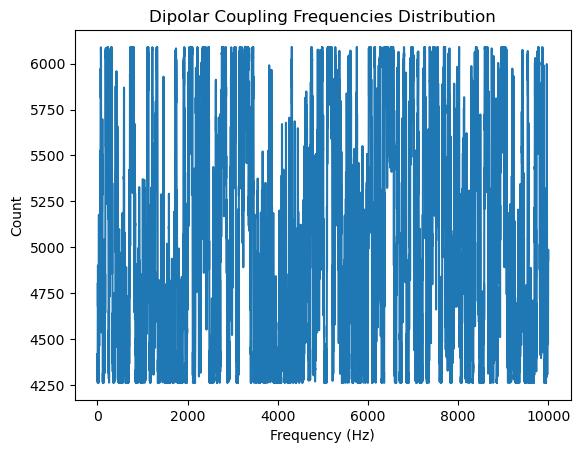

In [ ]:
# test the new xyz2freq_numpy function
B0 = 14.1
frequencies_test= xyz2freq_numpy(HN_vector, B0)
# plot frequencies_test
import matplotlib.pyplot as plt

plt.plot(frequencies_test)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('Dipolar Coupling Frequencies Distribution')
plt.show()  




In [93]:
# now we could use the new xyz2freq_numpy function
frequencies_ensemble = xyz2freq_numpy(ensem_vector, B0)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1062ef520>>
Traceback (most recent call last):
  File "/Users/yunyao_1/miniforge3/envs/nmr_py310/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [94]:
print(frequencies_ensemble.shape)

(10000, 1000)


In [95]:
# calculate Ix

Ix_ensemble, Iy_ensemble = calculate_Ip_trajectory(frequencies_ensemble, dt)
# calculate average_Ix
print(Ix_ensemble.shape)

(1000,)


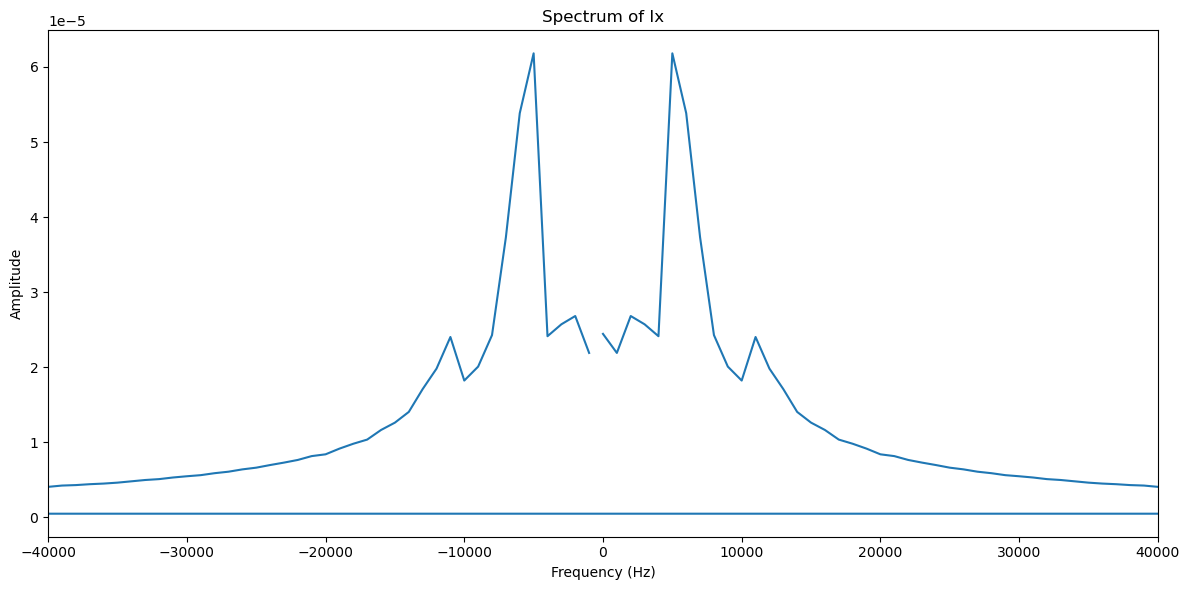

In [96]:
# calculate spectrum
def calculate_spectrum(Ix, Iy, dt):
    fft_vals= np.fft.fft(Ix)
    freq = np.fft.fftfreq(len(Ix), d=dt)
    #normalize
    fft_vals = fft_vals * dt
    return freq, fft_vals

freq, fft_vals = calculate_spectrum(Ix_ensemble, Iy_ensemble, dt)
# plot the spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(freq, np.abs(fft_vals))
plt.title('Spectrum of Ix')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(-40000, 40000)

plt.tight_layout()
plt.show()

In [100]:
%%writefile dynamics_dipolar_static.py
#!/usr/bin/env python3
import numpy as np
import argparse
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- utility dipolar prefactor ---
def dipolar_prefactor_Hz(r, gamma1, gamma2):
    mu0 = 4 * np.pi * 1e-7
    hbar = 1.054571817e-34
    return (mu0/(4*np.pi)) * (gamma1*gamma2*hbar)/(r**3) / (2*np.pi)  # Hz

# --- Step 1: Simulate vector trajectory on a cone ---
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)
    phi = 0.0
    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vectors[i] = np.array([x, y, z])
    return vectors

# --- Step 2: Convert vectors to dipolar frequencies ---
def xyz2freq_numpy(vectors, B0, r, gamma1, gamma2):
    vectors = np.array(vectors, dtype=float)
    norms = np.linalg.norm(vectors, axis=-1, keepdims=True)
    vectors /= norms
    
    original_shape = vectors.shape[:-1]
    vectors_flat = vectors.reshape(-1, 3)
    cos_theta = vectors_flat[:, 2]
    D = dipolar_prefactor_Hz(r, gamma1, gamma2)
    frequencies_flat = D * (3 * cos_theta**2 - 1) / 2
    frequencies = frequencies_flat.reshape(original_shape + (1,))
    return frequencies

# --- Step 3: Calculate Ix/Iy trajectory ---
def calculate_Ip_trajectory(frequencies, dt):
    frequencies = np.array(frequencies, dtype=float)
    delta_angles = 2 * np.pi * frequencies * dt
    cum_angles = np.cumsum(delta_angles, axis=1)
    Ix = np.cos(cum_angles)
    Iy = np.sin(cum_angles)
    Ix_avg = Ix.mean(axis=0).squeeze()
    Iy_avg = Iy.mean(axis=0).squeeze()
    return Ix_avg, Iy_avg

# --- Step 4: Calculate spectrum ---
def calculate_spectrum(Ix, dt):
    fft_vals = np.fft.fft(Ix)
    freq = np.fft.fftfreq(len(Ix), d=dt)
    fft_vals = fft_vals * dt
    return freq, fft_vals

# --- main script ---
def main():
    parser = argparse.ArgumentParser(description="Simulate dipolar NMR trajectories and spectra.")
    parser.add_argument("--S2", type=float, default=0.85, help="Order parameter (default 0.85)")
    parser.add_argument("--tau_c", type=float, default=0.01, help="Correlation time (default 0.01)")
    parser.add_argument("--dt", type=float, default=1e-4, help="Time step (default 1e-4)")
    parser.add_argument("--num_steps", type=int, default=10000, help="Number of time steps (default 10000)")
    parser.add_argument("--B0", type=float, default=14.1, help="Magnetic field in Tesla (default 14.1)")
    parser.add_argument("--r", type=float, required=True, help="Internuclear distance in meters")
    parser.add_argument("--gamma1", type=float, required=True, help="Gyromagnetic ratio of spin1 (rad/T/s)")
    parser.add_argument("--gamma2", type=float, required=True, help="Gyromagnetic ratio of spin2 (rad/T/s)")
    parser.add_argument("--plot", action="store_true", help="If set, plot the spectrum.")
    parser.add_argument("--N", type=int, default=10000, help="Number of ensemble members (default 10000)")
    parser.add_argument("--output_prefix", type=str, default=None, help="Prefix for saving results (optional)")
    args = parser.parse_args()

    # 1. simulate trajectory (single vector path)
    vectors = simulate_vector_on_cone(args.S2, args.tau_c, args.dt, args.num_steps)
    HN_vector = vectors  # base trajectory to rotate

    # 2. create ensemble by random rotation
    rot = R.random(num=args.N)
    rot_mtx = rot.as_matrix()          # shape (N,3,3)
    ensem_vector = np.einsum('nij,mj->nmi', rot_mtx, HN_vector)

    # 3. convert to frequencies
    freq_ensemble = xyz2freq_numpy(ensem_vector, args.B0, args.r, args.gamma1, args.gamma2)

    # 4. calculate Ix/Iy
    Ix_avg, Iy_avg = calculate_Ip_trajectory(freq_ensemble, args.dt)

    # 5. calculate spectrum
    freq, fft_vals = calculate_spectrum(Ix_avg, args.dt)

    # 6. save outputs if requested
    if args.output_prefix:
        np.save(f"{args.output_prefix}_Ix.npy", Ix_avg)
        np.save(f"{args.output_prefix}_Iy.npy", Iy_avg)
        np.save(f"{args.output_prefix}_freq.npy", freq)
        np.save(f"{args.output_prefix}_fft.npy", fft_vals)
        print(f"Saved results to {args.output_prefix}_*.npy")

    # 7. optional plot
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,4))
        plt.plot(freq, np.abs(fft_vals))
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Intensity")
        plt.title("Dipolar Spectrum")
        plt.grid(True)
        plt.show()

    return freq, fft_vals

if __name__ == "__main__":
    main()






Writing dynamics_dipolar_static.py
